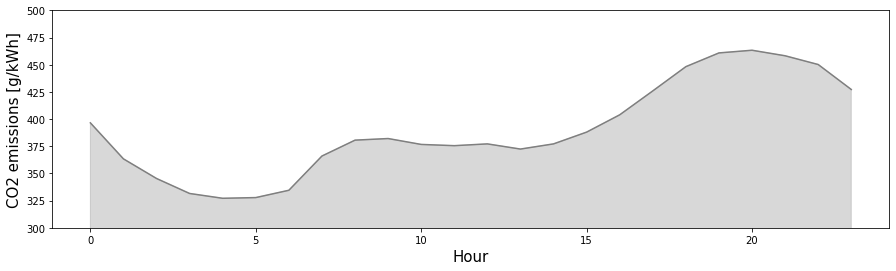

In [1]:
# Baseline model variable calculation

#libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob # library for reading all files in the folder
from matplotlib.lines import Line2D
import seaborn as sns

##########################################################################################
##########################################################################################
##########################################################################################
# Data import and p
Data = pd.read_csv('Data_Baseline.csv')

Monthly_coupling = Data[['Hour', 'Month', 'Electricity [MWh]','PV [MWh]']].copy()
for_balance = Monthly_coupling.groupby(['Month', 'Hour']).mean()
months = Monthly_coupling['Month'].unique()

hour = range(24)

month_balance={}
for month in months:
    month_balance[month] = for_balance.loc[month]

##########################################################################################
##########################################################################################
##########################################################################################
# Primary Energy Factors: 

PEF_Grid = 2.56 # Grid
PEF_PV = 1 # Photovoltaic electricity

##########################################################################################
##########################################################################################
##########################################################################################
# Calculations: 
Coupling = Monthly_coupling.copy() 
Coupling['CO2'] = Data['CO2'].copy() #CO2 hourly data
Coupling['Price'] = Data['Price'].copy() # Price hourly data
# Electricity balance 

Coupling['Coupling'] = Coupling['Electricity [MWh]'] - Coupling['PV [MWh]'] # balance variable

# Electricity taken form grid, from solar PV and exported to the grid:

Coupling['Grid Electricity [MWh]'] = np.where(Coupling['Coupling']> 0, Coupling['Coupling'], 0)
Coupling['PV Consumption [MWh]'] = np.where(Coupling['Electricity [MWh]']<Coupling['PV [MWh]'],Coupling['Electricity [MWh]'], Coupling['PV [MWh]'])
Coupling['PV Export [MWh]'] = (-1)*np.where(Coupling['Coupling'] <  0, Coupling['Coupling'], 0)
Coupling['Battery-supplied Electricity [MWh]'] = 0

# CO2 emissions 

Coupling['CO2 Emissions [kg]'] = Coupling['Grid Electricity [MWh]'] * Coupling['CO2']
Coupling['CO2 Avoided [kg]'] = Coupling['PV Consumption [MWh]'] * Coupling['CO2']
Coupling['CO2 Saved Exports [kg]'] = Coupling['PV Export [MWh]'] * Coupling['CO2']

#Cost of electricity

Coupling['Cost Electricity'] = Coupling['Grid Electricity [MWh]'] * Coupling['Price'] * 1000
Coupling['Cost saved PV'] = Coupling['PV Consumption [MWh]'] * Coupling['Price'] * 1000
Coupling['Cost Exports'] = Coupling['PV Export [MWh]'] * Coupling['Price'] * 1000

# Primary Energy Consumption

Coupling['PE Grid'] = Coupling['Grid Electricity [MWh]'] * PEF_Grid
Coupling['PE Solar'] = Coupling['PV Consumption [MWh]'] * PEF_PV
Coupling['PE Exports'] = Coupling['PV Export [MWh]'] * PEF_PV
Coupling['PE Final Balance'] = Coupling['PE Grid'] + Coupling['PE Solar'] + Coupling['PE Exports']
Coupling.to_csv('Coupling_data.csv')

##########################################################################################
##########################################################################################
##########################################################################################
# Exports needed in the other codes
# Export variable 'Coupling'

Balance = Coupling['Coupling'].copy()
Balance = Balance*(-1)
Balance = Balance.to_csv('Balance.csv')

# Export CO2 variable

CO2_emissions = Data[['CO2', 'Hour']].head(24).copy()
CO2_emissions['name'] = 'CO2'
plt.figure(figsize=(15, 4))
a = sns.lineplot(x = 'Hour', y= 'CO2',hue = 'name', data=CO2_emissions, palette='gray_r')
l1 = a.lines[0]
a.set_xlabel('Hour', fontsize = 15)
a.set(ylim=(300, 500))
a.set_ylabel('CO2 emissions [g/kWh]', fontsize = 15)
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
a.fill_between(x1,y1, color="grey", alpha=0.3)
a.get_legend().remove()
plt.savefig('CO2 emissions.pdf')
CO2_emissions.to_csv('CO2_hourly.csv')

##########################################################################################
##########################################################################################
##########################################################################################
# Export final results
# I reindex months because they lose the order when grouping
# Rename to have all models with the same variable names

Coupling.rename(columns = {'Electricity [MWh]' : 'Demand [MWh]', 'PV [MWh]' : 'PV Electricity [MWh]',
                          }, inplace = True)
Grouped_Coupling = Coupling.groupby(['Month']).sum().reindex(months).drop(['Hour'], axis = 1)
Grouped_Coupling['Months'] = months

Coupling.to_csv('Baseline_hourly.csv')
Grouped_Coupling.to_csv('Baseline_monthly.csv')